In [98]:
# Name - Dev Patel
# Roll No - 18110113

import numpy as np
import scipy
from scipy.optimize import fsolve
import scipy.integrate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sym

In [99]:
# Some constants
l1 = 0.25
l2 = 0.25
l3 = 0.25
g = 9.81
m1 = 100
m2 = 100
m3 = 100
m = 100
r = 0.01
d1 = 0.25
I1 = m*r*r/2 + m1*l1*l1/12
I2 = m2*l2*l2/12
I3 = m3*r*r/2

#end point coordinates
A = np.array([0.4,0.06,0.1])
B = np.array([0.4,0.01,0.1])


In [100]:
# Get a skew symmetric matrix for a given 3x1 matrix
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

#SCARA
def inverse_kinematics_SCARA(O):

    c2 = (O[0]**2 + O[1]**2 - l1**2 - l2**2)/(2*l1*l2)
    theta2 = np.arctan2(-(1-c2**2)**0.5,c2)
    theta1 = np.arctan2(O[1],O[0]) - np.arctan2(l2*np.sin(theta2),l1 + l2*np.cos(theta2))

    d3 = d1 - O[2] 

    I = np.array([theta1,theta2,d3])
    return(I)

q_i = inverse_kinematics_SCARA(A)
q_f = inverse_kinematics_SCARA(B)

def Jacobian_SCARA(DH_parameters):
    T = np.eye(4)
    O = np.array([0,0,0])
    Z = np.array([0,0,1])
    for i in range(4):
        A = np.array([[np.cos(DH_parameters[i,0]), -np.sin(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), np.sin(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.cos(DH_parameters[i,0])],\
                [np.sin(DH_parameters[i,0]), np.cos(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), -np.cos(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.sin(DH_parameters[i,0])],\
                    [0,np.sin(DH_parameters[i,3]),np.cos(DH_parameters[i,3]),DH_parameters[i,2]],\
                        [0,0,0,1]])

        T = np.dot(T,A)
        O = np.c_[O,np.transpose(T[:3,3])]
        Z = np.c_[Z,np.transpose(T[:3,2])]
    J = np.r_[np.dot(skew(Z[:,0]),np.transpose(O[:,3]) - np.transpose(O[:,0])), np.transpose(Z[:,0])]
    for i in range(1,4):
        if(i==4):
             J = np.c_[J,np.r_[np.transpose(Z[:,i]),np.transpose([0,0,0])]]
        else:
            J = np.c_[J,np.r_[np.dot(skew(Z[:,i]),np.transpose(O[:,3]) - np.transpose(O[:,i])), np.transpose(Z[:,i])]]
    return(J)

def end_Effector_position_SCARA(I):
    T = np.eye(4)
    DH_parameters = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l1,0,3.14],[0,0,I[2],0]])
    for i in range(4):
        A = np.array([[np.cos(DH_parameters[i,0]), -np.sin(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), np.sin(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.cos(DH_parameters[i,0])],\
                [np.sin(DH_parameters[i,0]), np.cos(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), -np.cos(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.sin(DH_parameters[i,0])],\
                    [0,np.sin(DH_parameters[i,3]),np.cos(DH_parameters[i,3]),DH_parameters[i,2]],\
                        [0,0,0,1]])

        T = np.dot(T,A)
    return(T[0:3,3])

In [101]:
# Getting the tajectory 
x = np.array([])
vx = np.array([])
ax = np.array([])

y = np.array([])
vy = np.array([])
ay = np.array([])

z = np.array([])
vz = np.array([])
az = np.array([])

T = np.array([])
for t in range(0,100,1):
    x = np.append(x,0.4)
    vx = np.append(vx,0)
    ax = np.append(ax,0)
    
    y = np.append(y,0.06 -0.5*((t/100)**3)+0.75*((t/100)**4)-0.3*((t/100)**5))
    vy = np.append(vy,-3*0.5*((t/100)**2)+4*0.75*((t/100)**3)-5*0.3*((t/100)**4))
    ay =np.append(ay,-6*0.5*((t/100))+12*0.75*((t/100)**2)-20*0.3*((t/100)**3))
    
    z = np.append(z,0.1)
    vz = np.append(vz,0)
    az = np.append(az,0)

    T = np.append(T,t/100)

q1 = np.array([])
q2 = np.array([])
d3 = np.array([])
for i in range(len(x)):
    I = inverse_kinematics_SCARA([x[i],y[i],z[i]])
    q1 = np.append(q1,I[0])
    q2 = np.append(q2,I[1])
    d3 = np.append(d3,I[2])

    
# Get desired joint velocity
q1_dot = np.array([])
q2_dot = np.array([])
d3_dot = np.array([])

for i in range(len(x)):
    V = np.array([vx[i],vy[i],vz[i],0,0,0])
    I = inverse_kinematics_SCARA([x[i],y[i],z[i]])
    DH = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l1,0,3.14],[0,0,I[2],0]])
    J = Jacobian_SCARA(DH)
    q_dot = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(V[:3]))
    q1_dot = np.append(q1_dot,q_dot[1])
    q2_dot = np.append(q2_dot,q_dot[2])
    d3_dot = np.append(d3_dot,q_dot[3])



In [102]:
# PD Controller
def SCARAmanipulator(t, y):
    '''
    function for the ODE solver - returns dy/dt of states
    '''

    d3_dot_n = y[5]
    omega2 = y[4]
    omega1 = y[3]
    d3_n = y[2]
    q2_n = y[1]
    q1_n = y[0]

    d11 = (m1*l1**2)/4 +m2*l1**2 + (m2*l2**2)/4 + m3*l1**2 + m3*l2**2 + I1 + I2 + I3 + (m2*l1*l2/2 + 2*m3*l1*l2)*np.cos(q2_n)
    d12 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2_n)
    d22 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3
    d23 = I3
    d33 = m3/4

    B =  -(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2_n)*omega1*omega2 - (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2_n)*omega2*omega2
    C = (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2_n)*omega1*omega1/2
    
    K2 = 9 # differential constant for q1
    K = -1000 # linear constant for q1

    X = 0.4
    Y = 0.06 -0.5*((t)**3)+0.75*((t)**4)-0.3*((t)**5)
    Z = 0.1
    [q1_d,q2_d,d3_d] = inverse_kinematics_SCARA([X,Y,Z])
    dydt = [omega1, omega2, d3_dot_n, (-B - d12*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d11 - I1) - K*(q1_d-q1_n) - K2*omega1, (d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2) - K*(q2_d - q2_n) - K2*omega2, (-1 - d23*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d33 - I3) - K*(d3_d - d3_n)- K2*d3_dot_n]
    
    return dydt

Q1 = q_i[0]
Q2 = q_i[1]
D3 = q_i[2]
omega1 = q1_dot[0]
omega2 = q2_dot[0]
    
initstate = [Q1,Q2, D3, omega1, omega2, 0] # initial states
timestep = 0.1

time = np.linspace(0, 1, 100) # define the time for which we want to solve


# solve the ODE
solution = solve_ivp(SCARAmanipulator, [0, time[-1]], initstate, t_eval= time) 


qs1 = solution.y[0]
qs2 = solution.y[1]
ds3 = solution.y[2]
omegas1 = solution.y[3]
omegas2 = solution.y[4]
ds3_dot = solution.y[5]


x_actual_a = np.array([])
y_actual_a = np.array([])
z_actual_a = np.array([])
for i in range(len(qs1)):
    E = end_Effector_position_SCARA([qs1[i],qs2[i],ds3[i]])
    x_actual_a = np.append(x_actual_a,E[0])
    y_actual_a = np.append(y_actual_a,E[1])
    z_actual_a = np.append(z_actual_a,E[2])


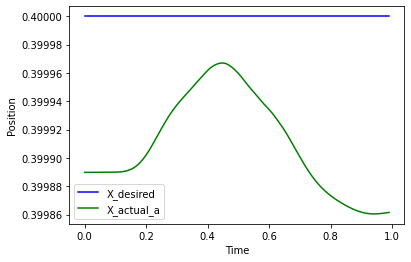

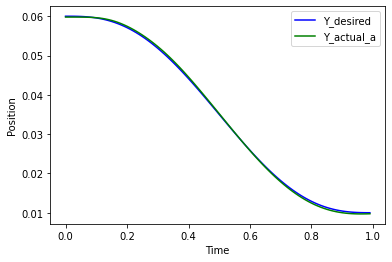

In [103]:
# plotting the results

plt.figure(1)
plt.plot(T,x,'b',T,x_actual_a,'g')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['X_desired','X_actual_a'])

plt.figure(2)
plt.plot(T,y,'b',T,y_actual_a,'g')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['Y_desired','Y_actual_a'])


In [104]:
# PD Feed Forward Control

def SCARAmanipulator(t, y):
    '''
    function for the ODE solver - returns dy/dt of states
    '''

    D3_dot = y[5]
    omega2 = y[4]
    omega1 = y[3]
    d3 = y[2]
    q2 = y[1]
    q1 = y[0]

    d11 = (m1*l1**2)/4 +m2*l1**2 + (m2*l2**2)/4 + m3*l1**2 + m3*l2**2 + I1 + I2 + I3 + (m2*l1*l2/2 + 2*m3*l1*l2)*np.cos(q2)
    d12 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2)
    d22 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3
    d23 = I3
    d33 = m3/4

    B =  -(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega2 - (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega2*omega2
    C = (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega1/2
    
    K2 = 9 # differential constant
    K = -1000 # linear constant

    X = 0.4
    Y = 0.06 -0.5*((t)**3)+0.75*((t)**4)-0.3*((t)**5)
    Z = 0.1
    [q1_d,q2_d,d3_d] = inverse_kinematics_SCARA([X,Y,Z])
    V = np.array([0,-3*0.5*((t)**2)+4*0.75*((t)**3)-5*0.3*((t)**4),0,0,0,0])
    A_e =np.array([0,-6*0.5*((t))+12*0.75*((t)**2)-20*0.3*((t)**3),0,0,0,0])
    I = inverse_kinematics_SCARA([X,Y,Z])
    DH = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l2,0,3.14],[0,0,I[2],0]])
    J = Jacobian_SCARA(DH)
    q_dot_d = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(V[:3]))
    J_dot = [[-l1*np.cos(q1_d)*q_dot_d[1]-l2*np.cos(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),-l2*np.cos(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),0],[-l1*np.sin(q1_d)*(q_dot_d[1])-l2*np.sin(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),-l2*np.sin(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]
    H = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(A_e[:3])) 
    G = np.matmul(J_dot[:3],np.transpose(np.array([q_dot_d[1],q_dot_d[2],q_dot_d[3]])))
    q_ddot_d = H[1:] - G

    dydt = [omega1, omega2, D3_dot, (-B - d12*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d11 - I1) - K*(q1_d-q1) + K2*(q_dot_d[1]-omega1) + q_ddot_d[0] ,
            (d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2) - K*(q2_d - q2) + K2*(q_dot_d[2]-omega2) + q_ddot_d[1], 
            (-1 - d23*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d33 - I3) - K*(q_f[2] - d3)+ K2*(q_dot_d[3]-D3_dot)+d33*q_ddot_d[2]]
    
    return dydt

Q1 = q_i[0]
Q2 = q_i[1]
D3 = q_i[2]
    
initstate = [Q1,Q2, D3, omega1, omega2, 0] # initial states
timestep = 0.1

time = np.linspace(0, 1, 100) # define the time for which we want to solve


# solve the ODE
solution = solve_ivp(SCARAmanipulator, [0, time[-1]], initstate, t_eval= time) 


qs1 = solution.y[0]
qs2 = solution.y[1]
ds3 = solution.y[2]
omegas1 = solution.y[3]
omegas2 = solution.y[4]
ds3_dot = solution.y[5]


x_actual_b = np.array([])
y_actual_b = np.array([])
z_actual_b = np.array([])
for i in range(len(qs1)):
    E = end_Effector_position_SCARA([qs1[i],qs2[i],ds3[i]])
    x_actual_b = np.append(x_actual_b,E[0])
    y_actual_b = np.append(y_actual_b,E[1])
    z_actual_b = np.append(z_actual_b,E[2])


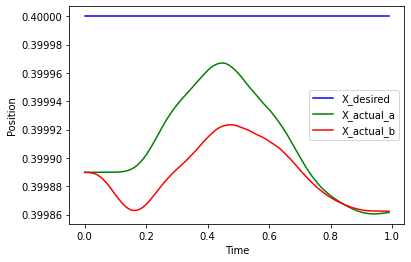

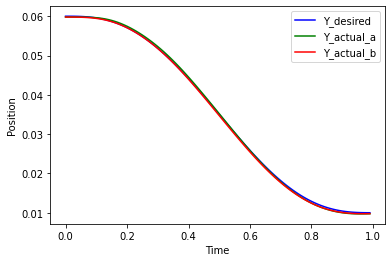

In [105]:
#plotting the results

plt.figure(1)
plt.plot(T,x,'b',T,x_actual_a,'g',T,x_actual_b,'r')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['X_desired','X_actual_a','X_actual_b'])

plt.figure(2)
plt.plot(T,y,'b',T,y_actual_a,'g',T,y_actual_b,'r')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['Y_desired','Y_actual_a','Y_actual_b'])



In [106]:
# Feed Forward Control Using computed torque

def SCARAmanipulator(t, y):
    '''
    function for the ODE solver - returns dy/dt of states
    '''

    D3_dot = y[5]
    omega2 = y[4]
    omega1 = y[3]
    d3 = y[2]
    q2 = y[1]
    q1 = y[0]

    d11 = (m1*l1**2)/4 +m2*l1**2 + (m2*l2**2)/4 + m3*l1**2 + m3*l2**2 + I1 + I2 + I3 + (m2*l1*l2/2 + 2*m3*l1*l2)*np.cos(q2)
    d12 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2)
    d22 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3
    d23 = I3
    d33 = m3/4

    B =  -(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega2 - (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega2*omega2
    C = (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega1/2
    
    K2 = 9 # differential constant
    K = -1000 # linear constant

    X = 0.4
    Y = 0.06 -0.5*((t)**3)+0.75*((t)**4)-0.3*((t)**5)
    Z = 0.1
    [q1_d,q2_d,d3_d] = inverse_kinematics_SCARA([X,Y,Z])
    V = np.array([0,-3*0.5*((t)**2)+4*0.75*((t)**3)-5*0.3*((t)**4),0,0,0,0])
    A_e =np.array([0,-6*0.5*((t))+12*0.75*((t)**2)-20*0.3*((t)**3),0,0,0,0])
    I = inverse_kinematics_SCARA([X,Y,Z])
    DH = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l2,0,3.14],[0,0,I[2],0]])
    J = Jacobian_SCARA(DH)
    q_dot_d = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(V[:3]))
    J_dot = [[-l1*np.cos(q1_d)*q_dot_d[1]-l2*np.cos(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),-l2*np.cos(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),0],[-l1*np.sin(q1_d)*(q_dot_d[1])-l2*np.sin(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),-l2*np.sin(q1_d+q2_d)*(q_dot_d[1]+q_dot_d[2]),0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]
    H = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(A_e[:3])) 
    G = np.matmul(J_dot[:3],np.transpose(np.array([q_dot_d[1],q_dot_d[2],q_dot_d[3]])))
    q_ddot_d = H[1:] - G

    tau1_d = ((m1*l1**2)/4 +m2*l1**2 + (m2*l2**2)/4 + m3*l1**2 + m3*l2**2 + I1 + I2 + I3 + (m2*l1*l2/2 + 2*m3*l1*l2)*np.cos(q2_d))*q_ddot_d[0] + ((m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2_d))*q_ddot_d[1] -(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2_d)*q_dot_d[1]*q_dot_d[2] - (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2_d)*q_dot_d[2]**2
    tau2_d =  ((m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2_d))*q_ddot_d[0] + d22*q_ddot_d[1] + (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2_d)*q_dot_d[1]*q_dot_d[1]/2
    tau3_d = d23*q_ddot_d[1] + d33*q_ddot_d[2] + 1
    
    dydt = [omega1, omega2, D3_dot, (-B - d12*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d11 - I1) - K*(q1_d-q1) + K2*(q_dot_d[1]-omega1) + q_ddot_d[0] + tau1_d/(d11 - I1) ,
             (d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2) - K*(q2_d - q2) + K2*(q_dot_d[2]-omega2) +(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*q_dot_d[1]**2/2+ q_ddot_d[1] +tau2_d/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2) ,   
             (-1 - d23*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d33 - I3) - K*(q_f[2] - d3)+ K2*(q_dot_d[3]-D3_dot) +q_ddot_d[2]+ tau3_d/(d33 - I3)]
    
    return dydt

Q1 = q_i[0]
Q2 = q_i[1]
D3 = q_i[2]
    
initstate = [Q1,Q2, D3, omega1, omega2, 0] # initial states
timestep = 0.1

time = np.linspace(0, 1, 100) # define the time for which we want to solve


# solve the ODE
solution = solve_ivp(SCARAmanipulator, [0, time[-1]], initstate, t_eval= time) 


qs1 = solution.y[0]
qs2 = solution.y[1]
ds3 = solution.y[2]
omegas1 = solution.y[3]
omegas2 = solution.y[4]
ds3_dot = solution.y[5]


x_actual_c = np.array([])
y_actual_c = np.array([])
z_actual_c = np.array([])
for i in range(len(qs1)):
    E = end_Effector_position_SCARA([qs1[i],qs2[i],ds3[i]])
    x_actual_c = np.append(x_actual_c,E[0])
    y_actual_c = np.append(y_actual_c,E[1])
    z_actual_c = np.append(z_actual_c,E[2])


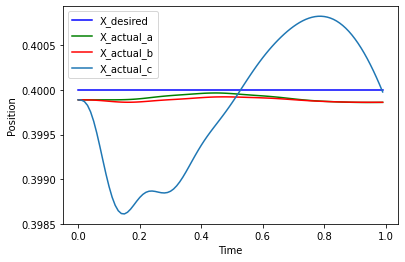

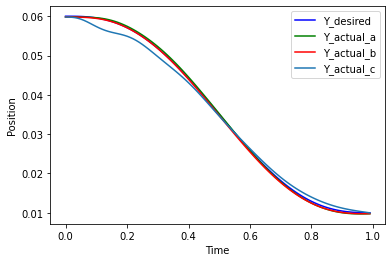

In [107]:
#plotting the results

plt.figure(1)
plt.plot(T,x,'b',T,x_actual_a,'g',T,x_actual_b,'r',T,x_actual_c)
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['X_desired','X_actual_a','X_actual_b','X_actual_c'])

plt.figure(2)
plt.plot(T,y,'b',T,y_actual_a,'g',T,y_actual_b,'r',T,y_actual_c)
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['Y_desired','Y_actual_a','Y_actual_b','Y_actual_c'])

In [116]:
# Multi Variable Control
def SCARAmanipulator(t, y):
    '''
    function for the ODE solver - returns dy/dt of states
    '''

    d3_dot = y[5]
    omega2 = y[4]
    omega1 = y[3]
    d3 = y[2]
    q2 = y[1]
    q1 = y[0]

    d11 = (m1*l1**2)/4 +m2*l1**2 + (m2*l2**2)/4 + m3*l1**2 + m3*l2**2 + I1 + I2 + I3 + (m2*l1*l2/2 + 2*m3*l1*l2)*np.cos(q2)
    d12 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3 + (m2*l1*l2 + 2*m3*l1*l2)*np.cos(q2)
    d22 = (m2*l2**2)/4 + m3*l2**2 + I2 + I3
    d23 = I3
    d33 = m3/4

    B =  -(m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega2 - (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega2*omega2
    C = (m2*l1*l2 + 2*m3*l1*l2)*np.sin(q2)*omega1*omega1/2
    
    K2 = 9 # differential constant
    K = -1000 # linear constant
    K3 = -2
    K4 = 1
    X = 0.4
    Y = 0.06 -0.5*((t)**3)+0.75*((t)**4)-0.3*((t)**5)
    Z = 0.1
    [q1_d,q2_d,d3_d] = inverse_kinematics_SCARA([X,Y,Z])
    dydt = [omega1, omega2, d3_dot, (-B - d12*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d11 - I1) - K*(q1_d-q1) - K2*omega1 - K3*(q2_d - q2) - K4*omega2, 
            (d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2) - K*(q2_d - q2) - K2*omega2 - K3*(q1_d-q1) - K4*omega1, 
            (-1 - d23*((d23/(d33-I3) + B*d12/(d11-I1) - C)/(d22 - d12*d12/(d11-I1) - d23*d23/(d33-I3) - I2)))/(d33 - I3) - K*(q_f[2] - d3)- K2*d3_dot]
    
    return dydt

Q1 = q_i[0]
Q2 = q_i[1]
D3 = q_i[2]
    
initstate = [Q1,Q2, D3, omega1, omega2, 0] # initial states
timestep = 0.1

time = np.linspace(0, 1, 100) # define the time for which we want to solve


# solve the ODE
solution = solve_ivp(SCARAmanipulator, [0, time[-1]], initstate, t_eval= time) 


qs1 = solution.y[0]
qs2 = solution.y[1]
ds3 = solution.y[2]
omegas1 = solution.y[3]
omegas2 = solution.y[4]
ds3_dot = solution.y[5]


x_actual_d = np.array([])
y_actual_d = np.array([])
z_actual_d = np.array([])
for i in range(len(qs1)):
    E = end_Effector_position_SCARA([qs1[i],qs2[i],ds3[i]])
    x_actual_d = np.append(x_actual_d,E[0])
    y_actual_d = np.append(y_actual_d,E[1])
    z_actual_d = np.append(z_actual_d,E[2])



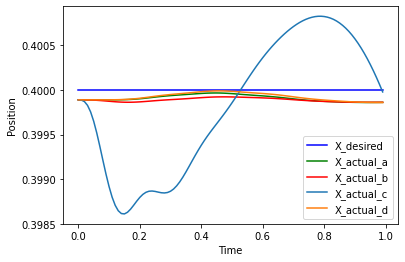

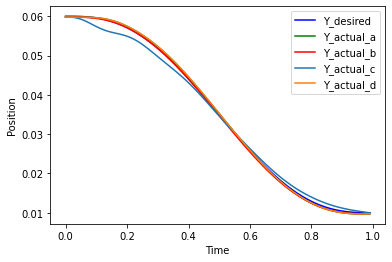

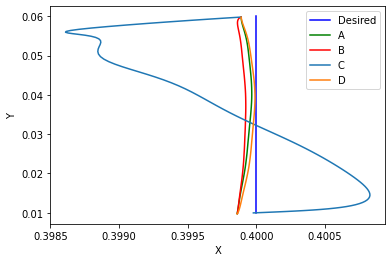

In [117]:
#plotting the results

plt.figure(1)
plt.plot(T,x,'b',T,x_actual_a,'g',T,x_actual_b,'r',T,x_actual_c,T,x_actual_d)
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['X_desired','X_actual_a','X_actual_b','X_actual_c','X_actual_d'])

plt.figure(2)
plt.plot(T,y,'b',T,y_actual_a,'g',T,y_actual_b,'r',T,y_actual_c,T,y_actual_d)
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['Y_desired','Y_actual_a','Y_actual_b','Y_actual_c','Y_actual_d'])

plt.figure(3)
plt.plot(x,y,'b',x_actual_a,y_actual_a,'g',x_actual_b,y_actual_b,'r',x_actual_c,y_actual_c,x_actual_d,y_actual_d)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Desired','A','B','C','D'])